In [2]:
%load_ext autoreload

import numpy as np
import numpy.random as npr
import torch
import scipy as sp
from scipy import interpolate
from collections import defaultdict

import json
import pandas as pd
import os
from tqdm import tqdm
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
plt.style.use('bmh')
from matplotlib import cm
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

import dmc2gym

import pickle as pkl
import itertools
import operator
from collections import namedtuple
from glob import glob
import textwrap

import os
import yaml

import sys
# sys.path.append('../batch')
# %autoreload 2
# %aimport bcq

import omegaconf
from omegaconf import OmegaConf

sys.path.append('..')
%autoreload 2
from common.analysis import plot_ac_exp

from IPython.display import display
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def sweep_summary(root):
    configs = {}
    all_summary = []
    for d in glob(f'{root}/*/'):
        eval_f = f'{d}/eval.csv'
        try:
            eval_df = pd.read_csv(eval_f)
        except:
            continue
        print
#         last_eval_rew = eval_df.episode_reward.values[-10:].mean()
        last_eval_rew = eval_df.episode_reward.values[-1]
        best_eval_rew = eval_df.episode_reward.values.max()
        fname = f'{d}/config.yaml'
        if not os.path.exists(fname):
            fname = f'{d}/.hydra/config.yaml'
            assert os.path.exists(fname)
        config = OmegaConf.load(fname)
        configs[d] = config
        fname = f'{d}/overrides.yaml'
        if not os.path.exists(fname):
            fname = f'{d}/.hydra/overrides.yaml'
            assert os.path.exists(fname)
        overrides = OmegaConf.load(fname)
        summary = dict(x.split('=') for x in overrides)
        summary['best_eval_rew'] = best_eval_rew
        summary['last_eval_rew'] = last_eval_rew
        summary['d'] = d
        all_summary.append(summary)
    
    if len(all_summary) == 0:
        print('No experiments with eval data found.')
        return [None]*4
        
    all_summary = pd.DataFrame(all_summary)
    for col in all_summary.columns:
        if col != 'env_name' and len(all_summary[col].unique()) == 1:
            all_summary.drop(col,inplace=True,axis=1)

    filt = ['env_name', 'seed']
    groups = [x.split('=')[0] for x in overrides]
    groups = [x for x in groups if x not in filt]
    groups = list(set(groups) & set(all_summary.columns))
#     groups = ['env_name'] + groups
    groups = all_summary.groupby(groups)

    return all_summary, groups, groups.agg(['mean', 'std']), configs

def plot_rew(root, ax=None, label=None):
    if ax is None:
        nrow, ncol = 1, 1
        fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol, 4*nrow))
        ax.set_xlabel('1k Updates')
    
    try:
        eval_df = pd.read_csv(f'{root}/eval.csv')
    except:
        return
    l, = ax.plot(eval_df.step/1000, eval_df.episode_reward, label=label)

def plot_rew_list(ds, title=None, ax=None):
    nrow, ncol = 1, 1
    if ax is None:
        fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol, 4*nrow))
    ax.set_xlabel('1k Updates')
#     ax.set_ylim(0, 1000)
    if title is not None:
        ax.set_title(title)
    for d in ds:
        label = d.split('/')[-2]
        plot_rew(d, ax=ax, label=label)
    ax.legend()

def plot_all_rew(root):
    nrow, ncol = 1, 1
    fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol, 4*nrow))
    ax.set_xlabel('1k Updates')
    title = '/'.join(root.split('/')[-3:])
    ax.set_title(title)
#     ax.set_ylim(0, 1000)
    for d in glob(f'{root}/*/'):
        label = d.split('/')[-2]
        plot_rew(d, fig=fig, label=label)
    ax.legend()

def plot_agg(df, agg, ncol=4):
    nrow = int(np.ceil(len(agg)/ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=(6*ncol, 4*nrow))
    axs = axs.ravel()
    for ax, (r, sub_df) in zip(axs, agg.iterrows()):
        if isinstance(r, str):
            r = [r]
        I = df.index == df.index
        for k, v in zip(agg.index.names, r):
            I = I & (df[k] == v)
        df_I = df[I]
        title = '.'.join([f'{k}={v}' for k,v in zip(agg.index.names, r)])
        title = title.replace('agent.params.', '').replace('model.params.', '')
        title = '\n'.join(textwrap.wrap(title, 45))
        plot_rew_list(df_I.d.values, title=title, ax=ax)
    fig.tight_layout()

def plot_ablation(
    groups, title, xmax=None,
    save=None, lw=3,
    xlabel='Timestep', ylabel='Reward',
    legend=False, sac_lim=None
):
    fig, ax = plt.subplots(1, 1, figsize=(4.5,3))

    for group in groups:
        all_df = []
        min_step = None
        for root in group['roots']:
            eval_f = f'{root}/eval.csv'
            df = pd.read_csv(eval_f)
            if min_step is None or max(df['step']) < min_step:
                min_step = max(df['step'])
            df['f'] = eval_f
            all_df.append(df)

        step_interp = np.linspace(0, min_step, num=20)
        all_df_interp = []
        for df in all_df:
            rew_interp = np.interp(step_interp, df['step'], df['episode_reward'])
            df_interp = pd.DataFrame({'step': step_interp, 'rew': rew_interp})
            all_df_interp.append(df_interp)
        all_df_interp = pd.concat(all_df_interp)
        label = group['tag'] if legend else None
        if 'color' in group:
            sns.lineplot(x='step', y='rew', data=all_df_interp,
                         ax=ax, linewidth=lw, label=label, color=group['color'])
        else:
            sns.lineplot(x='step', y='rew', data=all_df_interp,
                         ax=ax, linewidth=lw, label=label)
                
    ax.axhline(sac_lim, lw=lw, linestyle='--', color='k')

    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    if xmax is not None:
        ax.set_xlim(0, xmax)

    ax.set_xlabel('Timestep')
    ax.set_ylabel('Reward')
    ax.set_title(title)
    fig.tight_layout()
    
    if save is not None:
        fig.savefig(save)
        os.system(f'convert -trim {save} {save}')

best_eval_rew             last_eval_rew  \
                                     mean         std          mean   
env                                                                   
dmc_acrobot_swingup            383.774384    4.910053    365.549281   
dmc_cartpole_balance           999.677142    0.051647    998.935388   
dmc_cartpole_balance_sparse   1000.000000    0.000000   1000.000000   
dmc_cartpole_swingup           871.393541    6.973654    869.618449   
dmc_cartpole_swingup_sparse    849.000000    1.732051    848.100000   
dmc_cheetah_run                905.492456    2.328800    883.972850   
dmc_finger_spin                986.766667    1.274101    984.133333   
dmc_finger_turn_easy           983.333333    2.122106    981.733333   
dmc_finger_turn_hard           742.666667  413.240999    686.466667   
dmc_hopper_hop                 424.074929  153.705256    423.564600   
dmc_hopper_stand               953.048922    0.432792    944.825082   
dmc_pendulum_swingup           822.600000    1.743560    820.166667   
dmc_quadruped_run              852.271260   25.784769    815.839542   
dmc_quadruped_walk             974.972996    3.883642    973.159325   
dmc_reacher_easy               986.766667    0.251661    986.433333   
dmc_reacher_hard               978.833333    5.200321    978.766667   
dmc_walker_run                 847.338889    6.268665    843.067842   
dmc_walker_stand               987.470387    1.543658    983.254269   
dmc_walker_walk                978.204962    1.025547    973.969249   

                                         
                                    std  
env                                      
dmc_acrobot_swingup            3.689471  
dmc_cartpole_balance           0.793053  
dmc_cartpole_balance_sparse    0.000000  
dmc_cartpole_swingup           7.196970  
dmc_cartpole_swingup_sparse    1.835756  
dmc_cheetah_run               33.615466  
dmc_finger_spin                2.013289  
dmc_finger_turn_easy           0.901850  
dmc_finger_turn_hard         430.613357  
dmc_hopper_hop               154.285533  
dmc_hopper_stand               8.903003  
dmc_pendulum_swingup           1.877054  
dmc_quadruped_run             61.957558  
dmc_quadruped_walk             5.113139  
dmc_reacher_easy               0.351188  
dmc_reacher_hard               5.101307  
dmc_walker_run                 6.732091  
dmc_walker_stand               3.839017  
dmc_walker_walk                2.872644

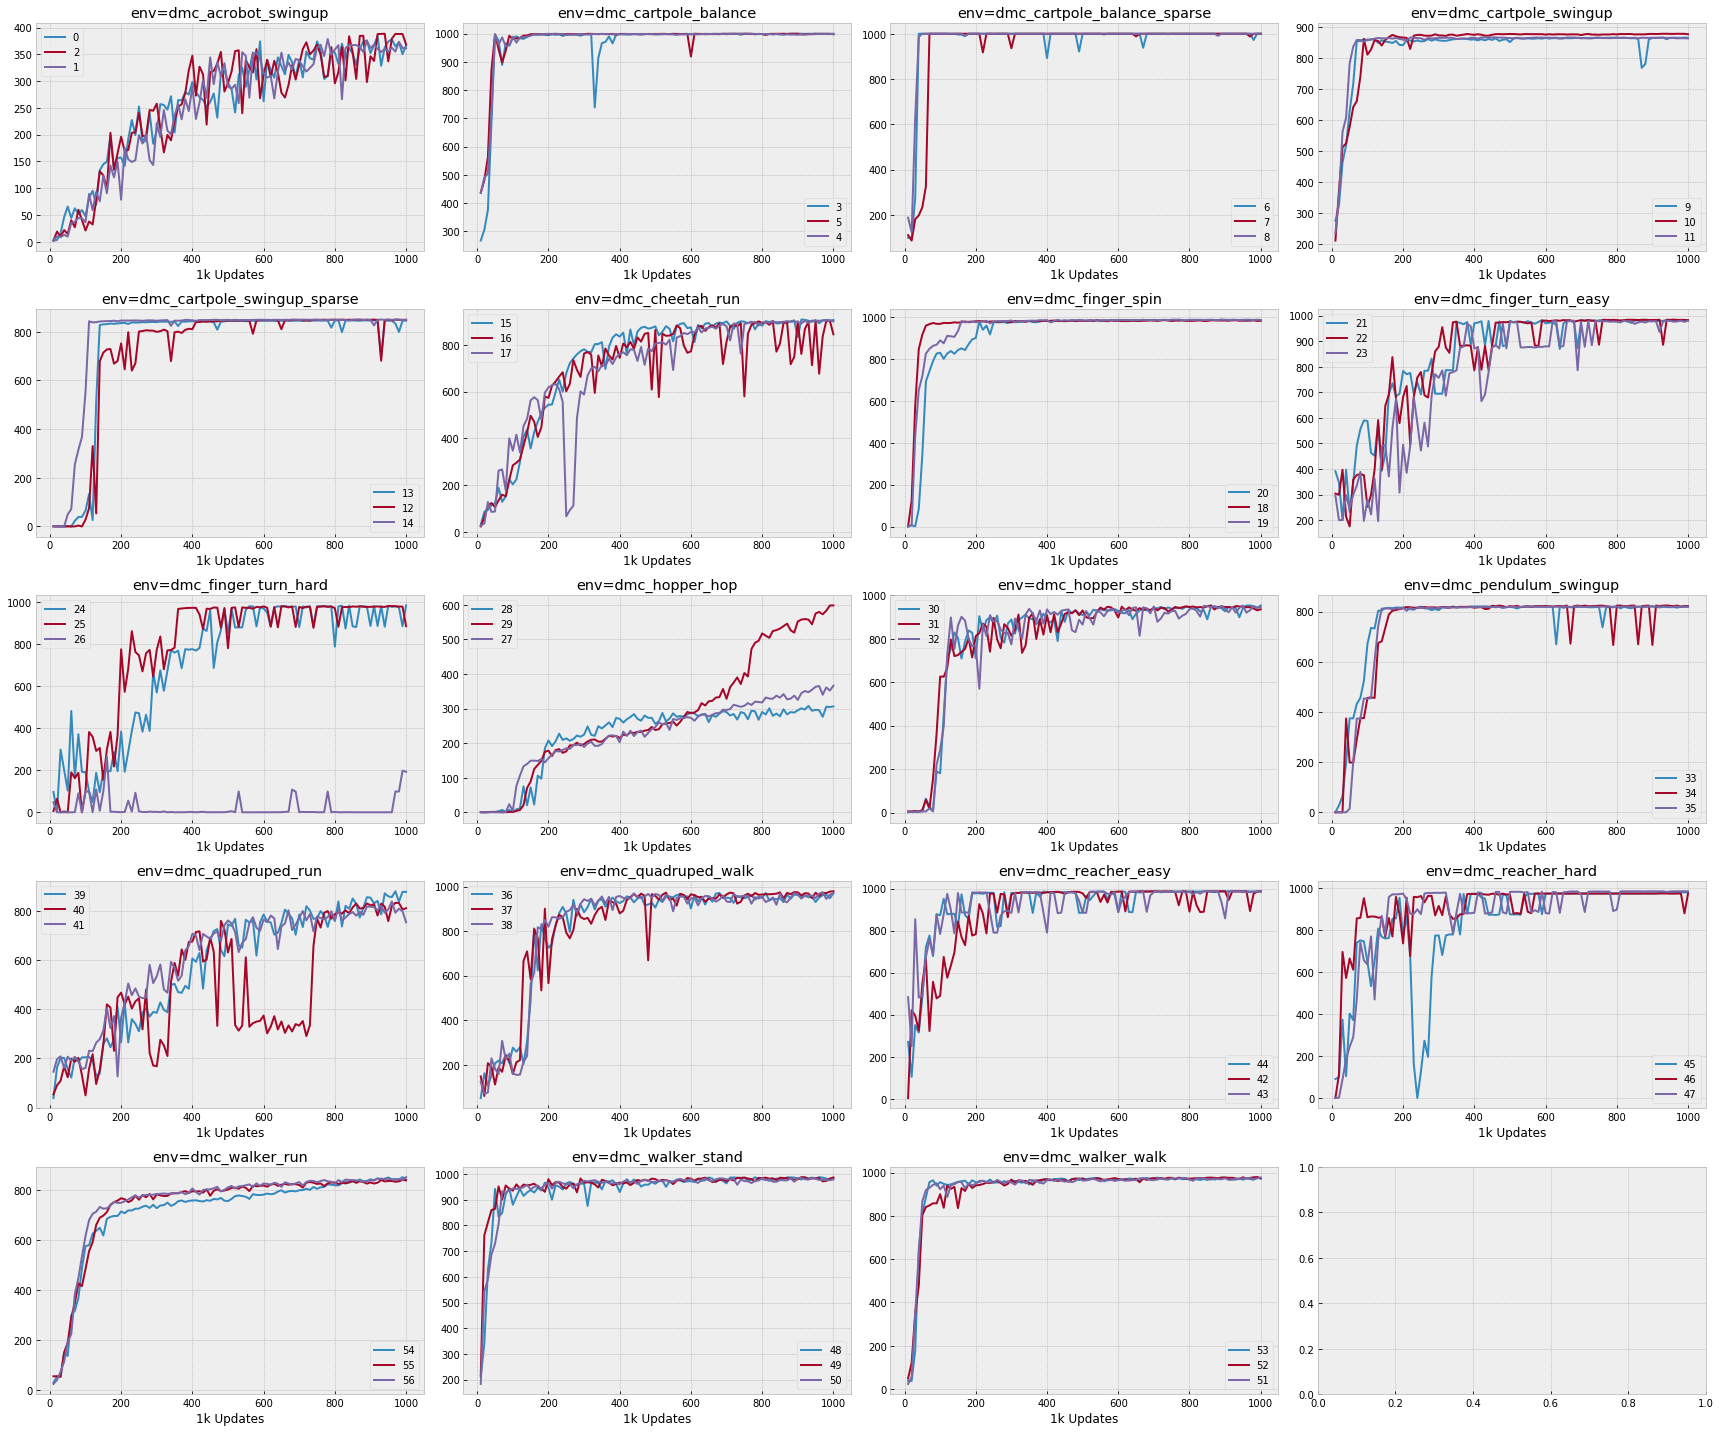

In [4]:
d = '../exp/2020.03.10/1206_sac_mve_dreamer_dmc_sac/'
all_summary, groups, agg, configs = sweep_summary(d)
# display(all_summary)
display(agg)
plot_agg(all_summary, agg, ncol=4)

In [5]:
agg.last_eval_rew['mean'].values.mean()

861.1345198634526

best_eval_rew             last_eval_rew  \
                                          mean         std          mean   
learn_temp.params.init_targ_entr                                           
-1                                  359.565432   21.743328    356.317281   
-2                                  380.254732   26.174124    377.498363   
-3                                  345.740147   73.449235    342.890478   
-4                                  456.531013  180.199376    455.141716   
0                                   437.538419  115.226710    418.899295   

                                              
                                         std  
learn_temp.params.init_targ_entr              
-1                                 21.120467  
-2                                 26.178291  
-3                                 72.966923  
-4                                180.830925  
0                                  89.721332

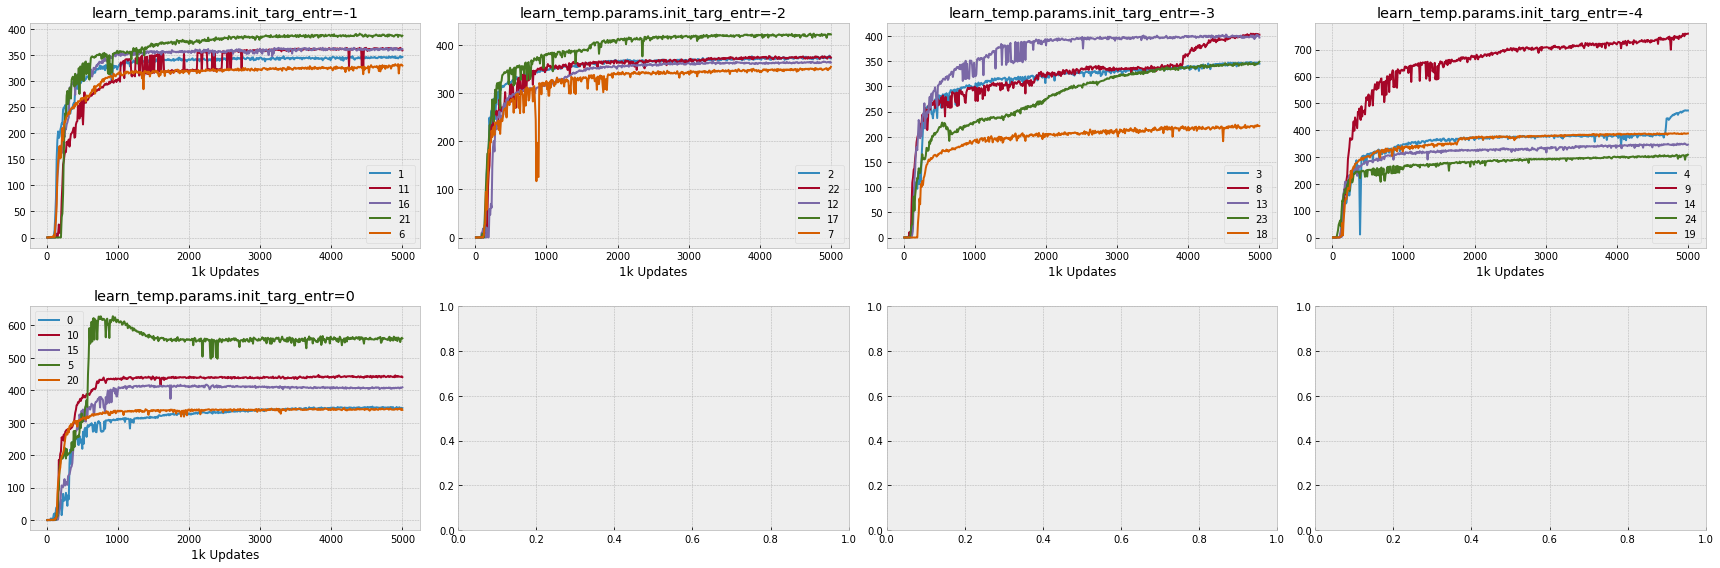

In [10]:
d = '../exp/2020.03.12/1437_sac_mve_dmc_hopper_targ_entr/'
all_summary, groups, agg, configs = sweep_summary(d)
# display(all_summary)
display(agg)
plot_agg(all_summary, agg, ncol=4)

['env=dmc_hopper_hop', 'obs_enc=proprio_identity', 'experiment=dmc_hopper_targ_entr', 'agent.params.horizon=1', 'seed=2', 'learn_temp.params.init_targ_entr=-4', 'learn_temp.params.entr_decay_factor=0.']
['env=dmc_hopper_hop', 'obs_enc=proprio_identity', 'experiment=dmc_hopper_targ_entr', 'agent.params.horizon=1', 'seed=1', 'learn_temp.params.init_targ_entr=-4', 'learn_temp.params.entr_decay_factor=0.']


(<Figure size 1296x576 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f51c0b12198>,
       dtype=object))

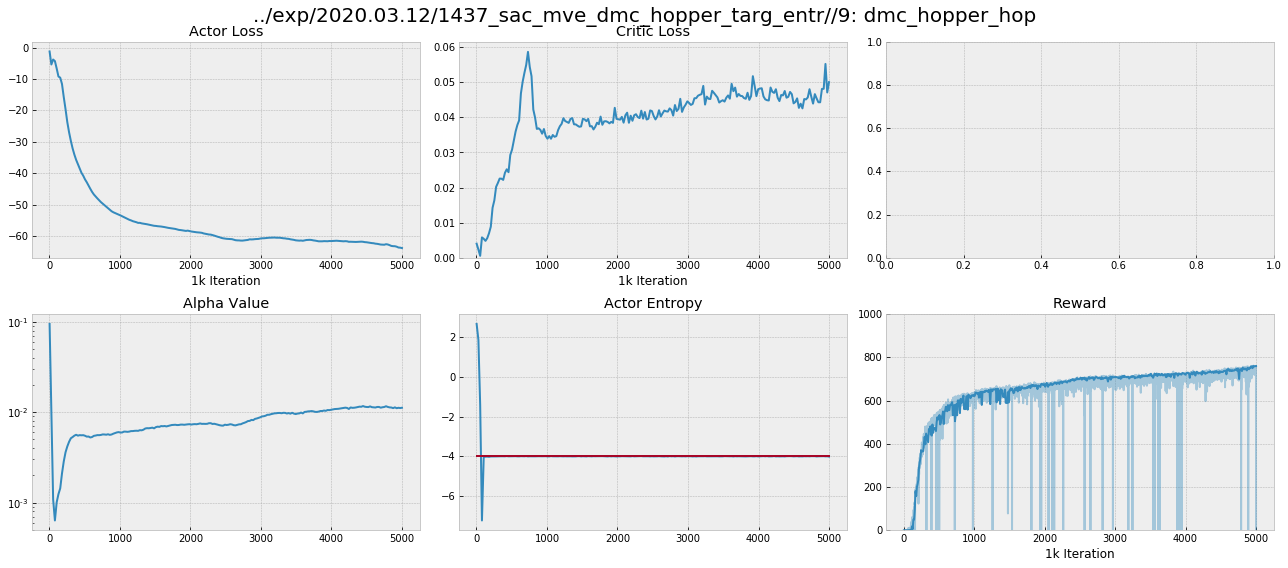

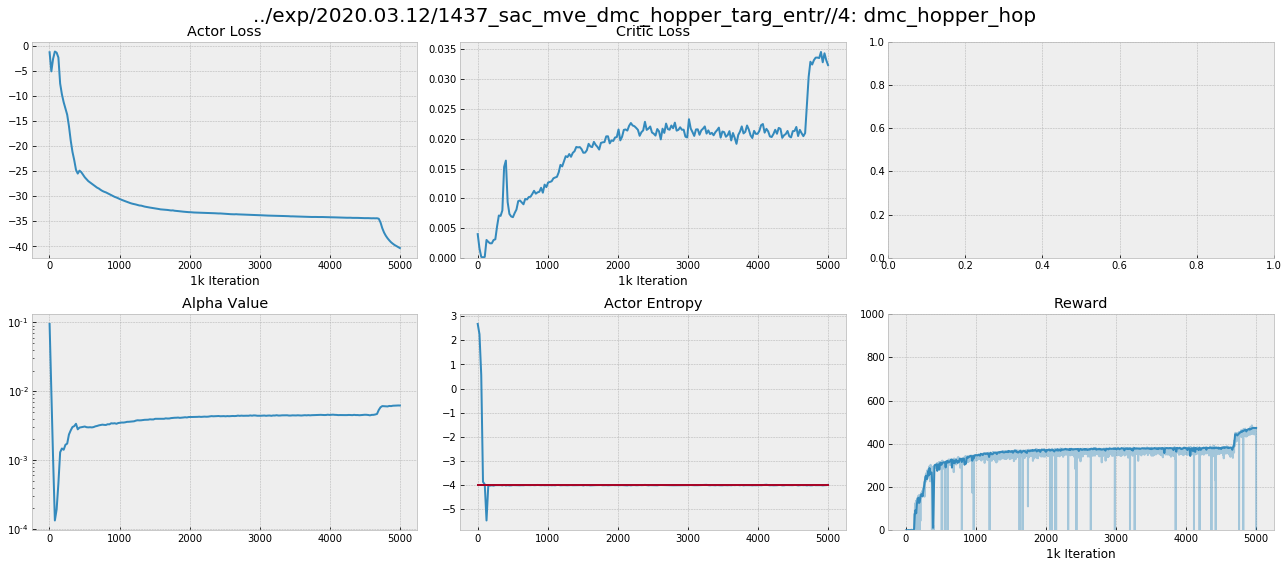

In [11]:
plot_ac_exp(f'{d}/9')
plot_ac_exp(f'{d}/4')

best_eval_rew  \
                                                                        mean   
agent.params.obs_latent_penalty agent.params.obs_recon_penalty                 
0                               0                                  48.478963   
                                1e-7                               45.442828   
1e-7                            0                                 257.549563   
                                1e-7                              297.267632   

                                                                            \
                                                                       std   
agent.params.obs_latent_penalty agent.params.obs_recon_penalty               
0                               0                                11.649317   
                                1e-7                             15.955329   
1e-7                            0                               377.479454   
                                1e-7                            453.675133   

                                                               last_eval_rew  \
                                                                        mean   
agent.params.obs_latent_penalty agent.params.obs_recon_penalty                 
0                               0                                  34.334443   
                                1e-7                               20.995619   
1e-7                            0                                 246.607771   
                                1e-7                              267.200085   

                                                                            
                                                                       std  
agent.params.obs_latent_penalty agent.params.obs_recon_penalty              
0                               0                                11.188131  
                                1e-7                              2.620565  
1e-7                            0                               381.442050  
                                1e-7                            417.922952

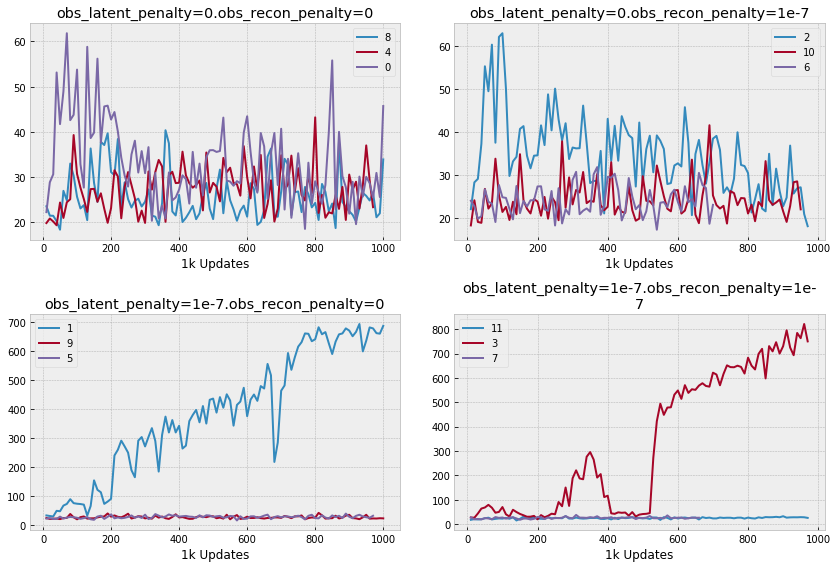

In [17]:
d = '../exp/2020.03.13/0645_sac_mve_dmc_walker_enc_pixels/'
all_summary, groups, agg, configs = sweep_summary(d)
# display(all_summary)
display(agg)
plot_agg(all_summary, agg, ncol=2)

['env=dmc_walker_walk', 'obs_enc=pixel_CNN', 'experiment=dmc_walker_enc_pixels', 'agent.params.horizon=1', 'seed=1', 'agent.params.obs_recon_penalty=1e-7', 'agent.params.obs_latent_penalty=1e-7']
['env=dmc_walker_walk', 'obs_enc=pixel_CNN', 'experiment=dmc_walker_enc_pixels', 'agent.params.horizon=1', 'seed=2', 'agent.params.obs_recon_penalty=1e-7', 'agent.params.obs_latent_penalty=1e-7']


(<Figure size 1296x576 with 7 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f51ba479828>,
       dtype=object))

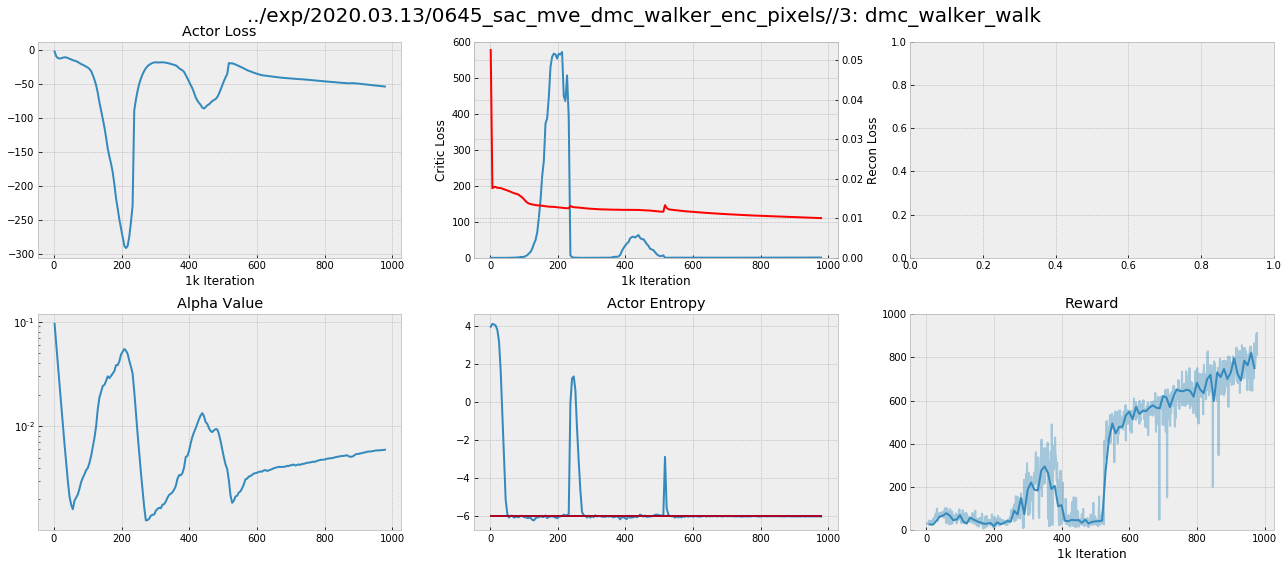

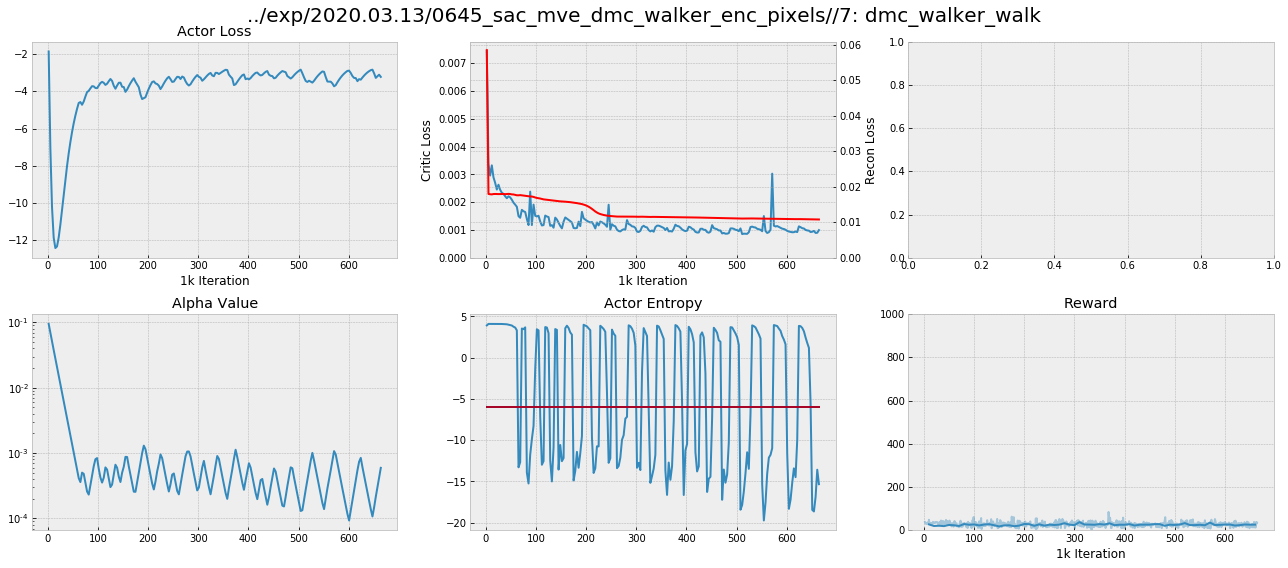

In [19]:
plot_ac_exp(f'{d}/3')
plot_ac_exp(f'{d}/7')

['env=dmc_walker_walk', 'obs_enc=pixel_CNN', 'experiment=dmc_walker_enc_pixels', 'agent.params.horizon=1', 'seed=2', 'agent.params.obs_recon_penalty=1e-7', 'agent.params.obs_latent_penalty=1e-7']


(<Figure size 1296x576 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f51c206bc18>,
       dtype=object))

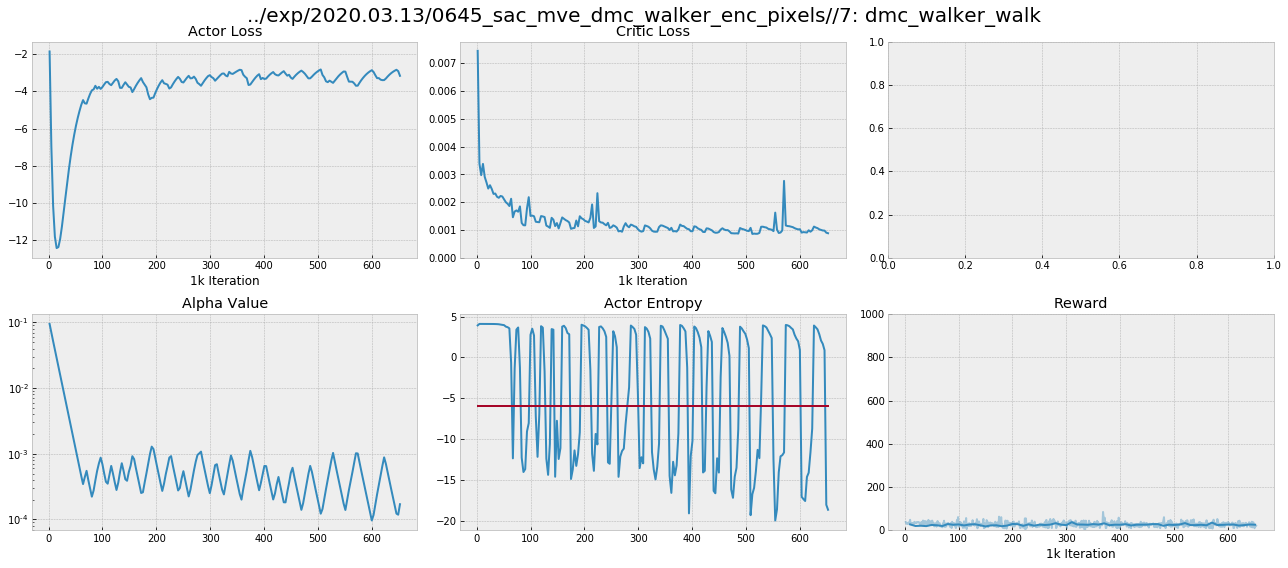

In [15]:
plot_ac_exp(f'{d}/7')

best_eval_rew            last_eval_rew           
                              mean        std          mean        std
agent.params.horizon                                                  
0                        37.909361  11.258653     26.802136  11.428564
1                        37.847080  18.637976     27.581267   9.004856

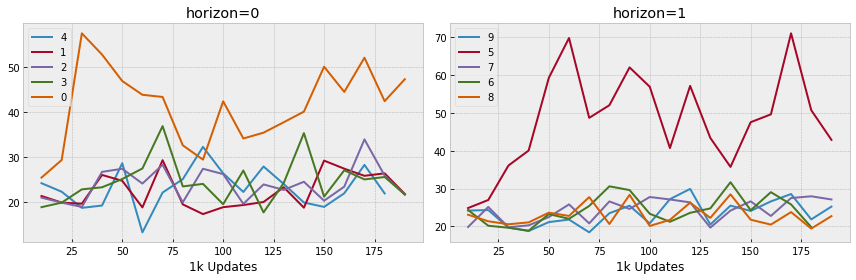

In [35]:
d = '../exp/2020.03.17/1517_sac_mve_dmc_walker_enc_pixels/'
all_summary, groups, agg, configs = sweep_summary(d)
# display(all_summary)
display(agg)
plot_agg(all_summary, agg, ncol=2)

['env=dmc_walker_walk', 'obs_enc=pixel_CNN', 'experiment=dmc_walker_enc_pixels', 'agent.params.horizon=0', 'seed=1', 'agent.params.obs_recon_penalty=1e-4', 'agent.params.obs_latent_penalty=1e-4']
['env=dmc_walker_walk', 'obs_enc=pixel_CNN', 'experiment=dmc_walker_enc_pixels', 'agent.params.horizon=0', 'seed=2', 'agent.params.obs_recon_penalty=1e-4', 'agent.params.obs_latent_penalty=1e-4']
['env=dmc_walker_walk', 'obs_enc=pixel_CNN', 'experiment=dmc_walker_enc_pixels', 'agent.params.horizon=1', 'seed=1', 'agent.params.obs_recon_penalty=1e-4', 'agent.params.obs_latent_penalty=1e-4']
['env=dmc_walker_walk', 'obs_enc=pixel_CNN', 'experiment=dmc_walker_enc_pixels', 'agent.params.horizon=1', 'seed=2', 'agent.params.obs_recon_penalty=1e-4', 'agent.params.obs_latent_penalty=1e-4']


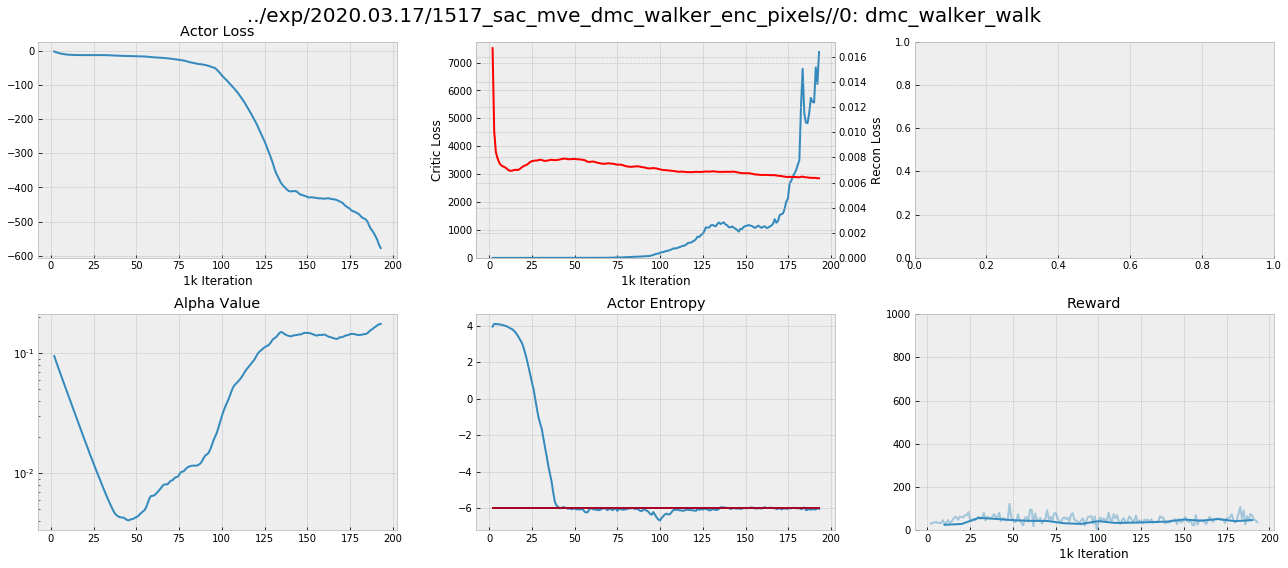

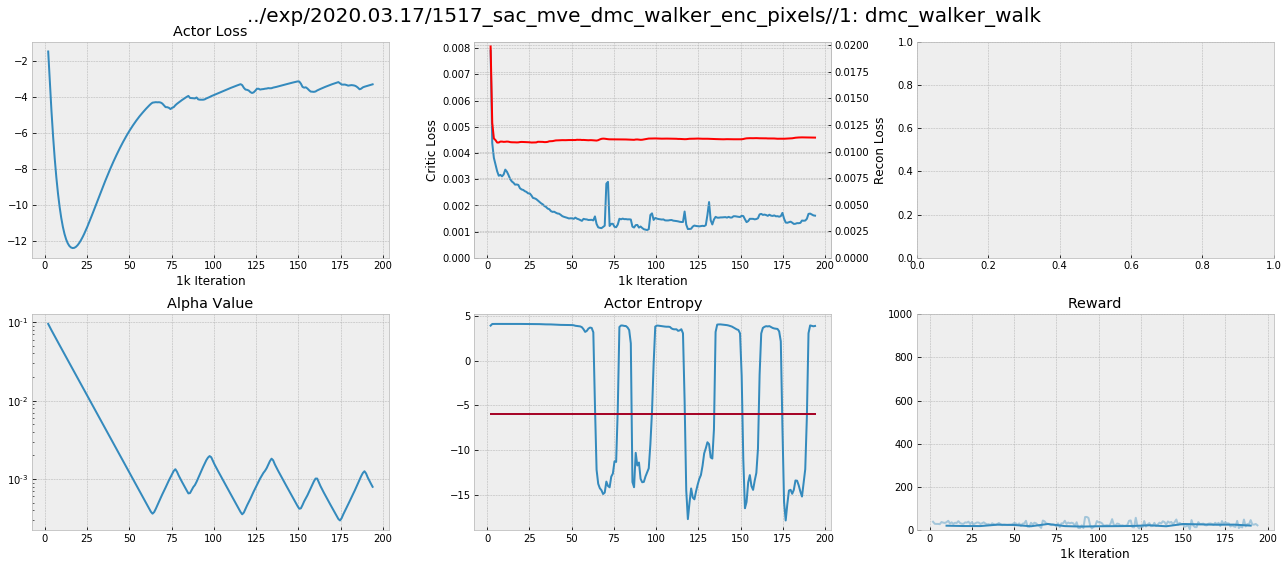

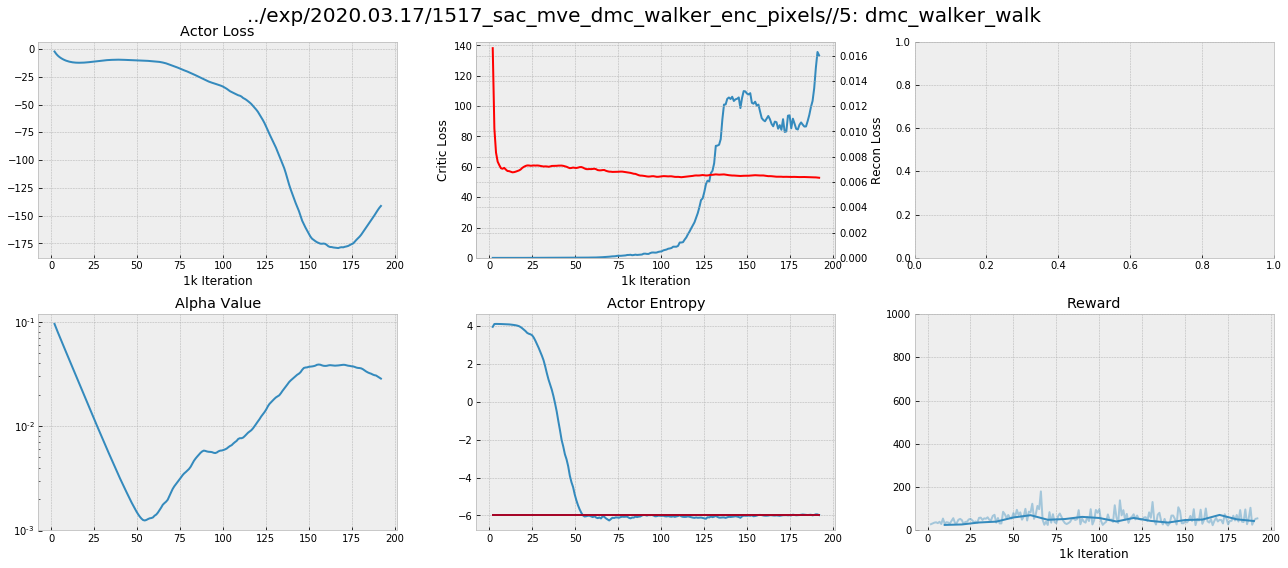

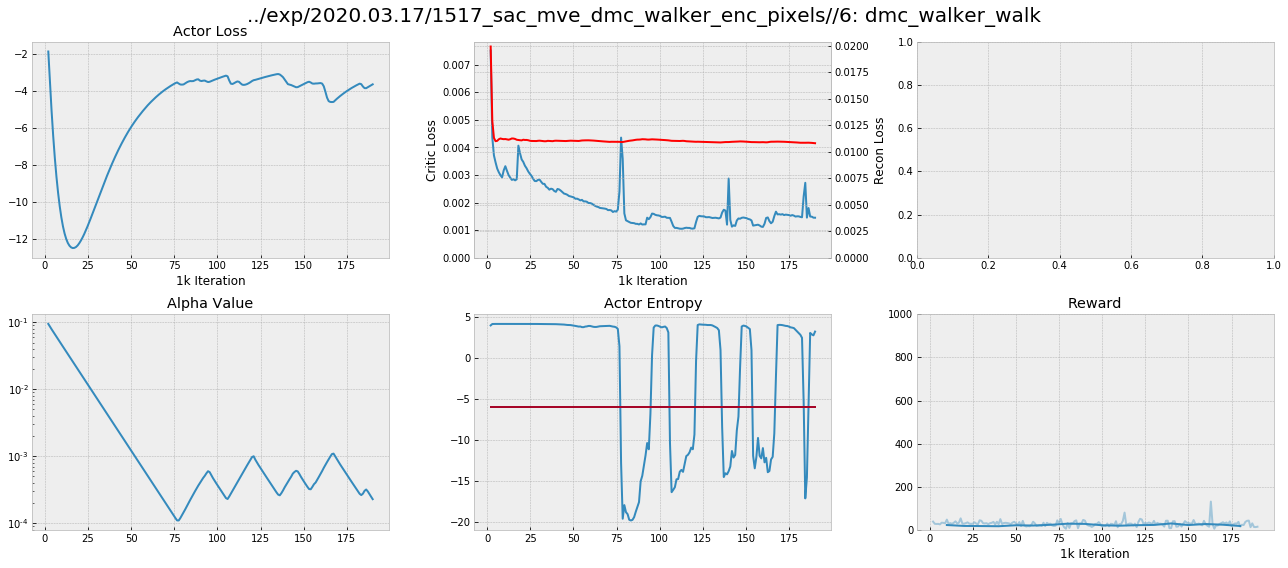

In [36]:
for i in [0,1,5,6]:
    plot_ac_exp(f'{d}/{i}')